# Проект промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## План

Шаг 1. Загрузка данных, исследовательский анализ и предобработка данных

Шаг 2. Объединение данных и анализ датафрейма

Шаг 3. Подготовка данных

Шаг 4. Обучение моделей машинного обучения

Шаг 5. Выбор лучшей модели

Шаг 6. Общий вывод и рекомендации заказчику


## Загрузка и предобработка данных

In [6]:
!pip install shap 

In [7]:
!pip install catboost

In [8]:
!pip install lightgbm

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,  MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

In [10]:
RANDOM_STATE = 40624
TEST_SIZE = 0.25

In [11]:
# data arc new
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    
# data_bulk_new.csv    
try:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

# data_bulk_time_new.csv
try:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    
# data_gas_new.csv
try:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    
# data_temp_new.csv
try:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    
# data_wire_new.csv
try:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    
# data_wire_time_new.csv
try:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [12]:
tables = ['data_arc_new', 
          'data_bulk_new', 
          'data_bulk_time_new', 
          'data_gas_new', 
          'data_temp_new', 
          'data_wire_new', 
          'data_wire_time_new']

### data_arc_new

In [14]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [15]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [16]:
data_arc_new = data_arc_new.rename(columns = {'Начало нагрева дугой': 'arc_heating_start', 
                                   'Конец нагрева дугой': 'arc_heating_finish', 
                                   'Активная мощность': 'apparent_power', 
                                   'Реактивная мощность': 'reactive_power'})

In [17]:
data_arc_new['arc_heating_start'] = pd.to_datetime(data_arc_new['arc_heating_start'])
data_arc_new['arc_heating_finish'] = pd.to_datetime(data_arc_new['arc_heating_finish'])

Добавим признак времени нагрева в секундах

In [19]:
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_finish'] - data_arc_new['arc_heating_start']
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_time'].dt.seconds

Добавим признак полная мощность, который вычисляется как sqrt(P^2+Q^2)

In [21]:
data_arc_new['full_power'] = (data_arc_new['apparent_power']**2 + data_arc_new['reactive_power']**2)**0.5

In [22]:
data_arc_new.head()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934


#### Предобработка

In [24]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_heating_start   14876 non-null  datetime64[ns]
 2   arc_heating_finish  14876 non-null  datetime64[ns]
 3   apparent_power      14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
 5   arc_heating_time    14876 non-null  int32         
 6   full_power          14876 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(1)
memory usage: 755.6 KB


In [25]:
data_arc_new.duplicated().sum()

0

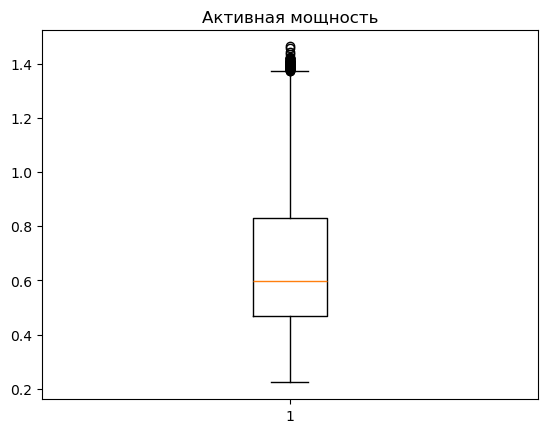

In [26]:
plt.boxplot(data_arc_new['apparent_power'])
plt.title('Активная мощность')
plt.show()

In [27]:
data_arc_new['reactive_power']

0        0.211253
1        0.477438
2        0.430460
3        0.379979
4        0.643691
           ...   
14871    0.299579
14872    0.458240
14873    0.769302
14874    0.361543
14875    0.251347
Name: reactive_power, Length: 14876, dtype: float64

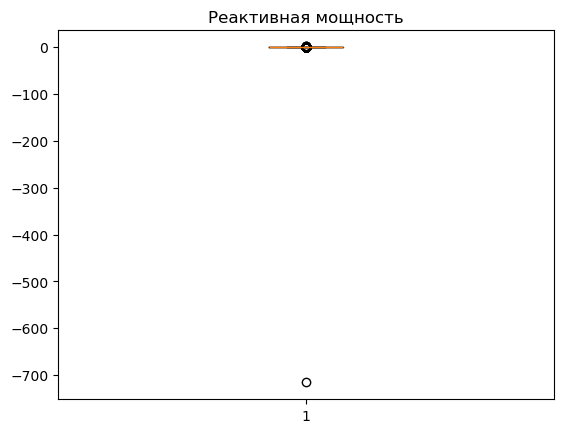

In [28]:
plt.boxplot(data_arc_new['reactive_power'])
plt.title('Реактивная мощность')
plt.show()

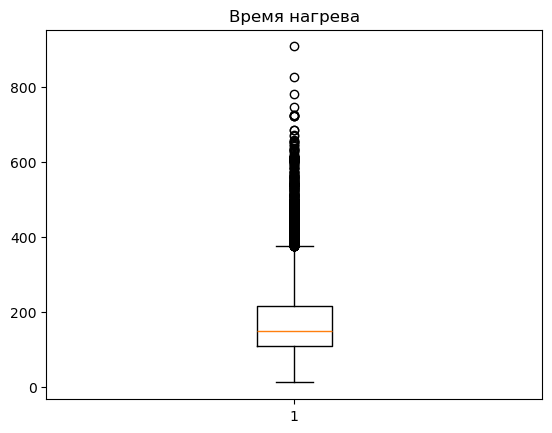

In [29]:
plt.boxplot(data_arc_new['arc_heating_time'])
plt.title('Время нагрева')
plt.show()

Удалим аномальные значения у реактивной мощности, а так же весь key, к которому относилось это значение

In [31]:
data_arc_new.loc[data_arc_new['reactive_power'] < -100]

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109,715.480272


In [32]:
data_arc_new.loc[data_arc_new['key'] == 2116]

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881,122,1.049621
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498,135,0.711362
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109,715.480272
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513,67,0.696114


In [33]:
data_arc_new = data_arc_new.drop(data_arc_new[data_arc_new['key'] == 2116].index)

data_arc_new = data_arc_new.query('reactive_power > -100')

#### Исследовательский анализ данных

In [36]:
BINS = int(math.sqrt(data_arc_new['key'].count()))
BINS

121

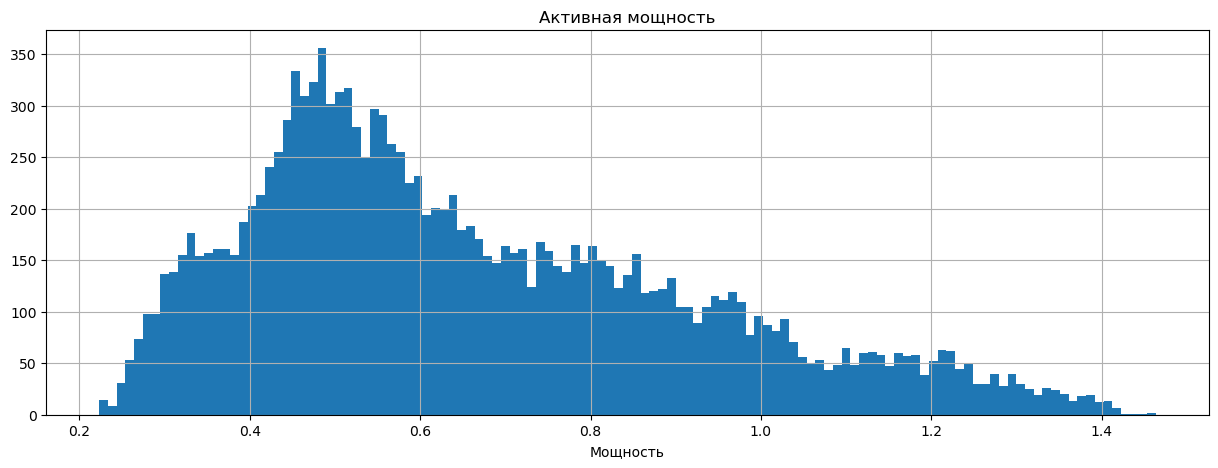

In [37]:
data_arc_new['apparent_power'].hist(bins=BINS, figsize=(15,5))
plt.title('Активная мощность')
plt.xlabel('Мощность')
plt.show()

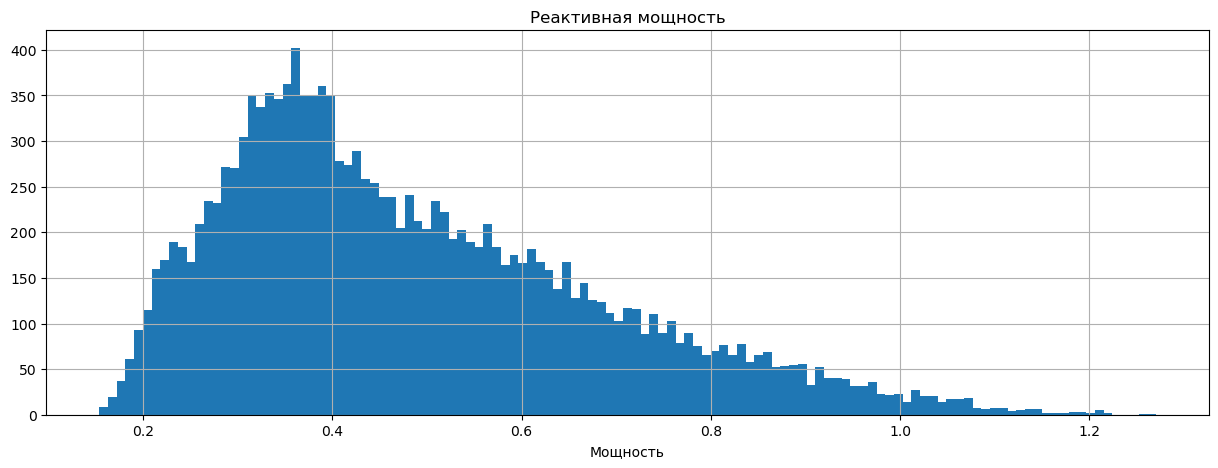

In [38]:
data_arc_new['reactive_power'].hist(bins=BINS, figsize=(15,5))
plt.title('Реактивная мощность')
plt.xlabel('Мощность')
plt.show()

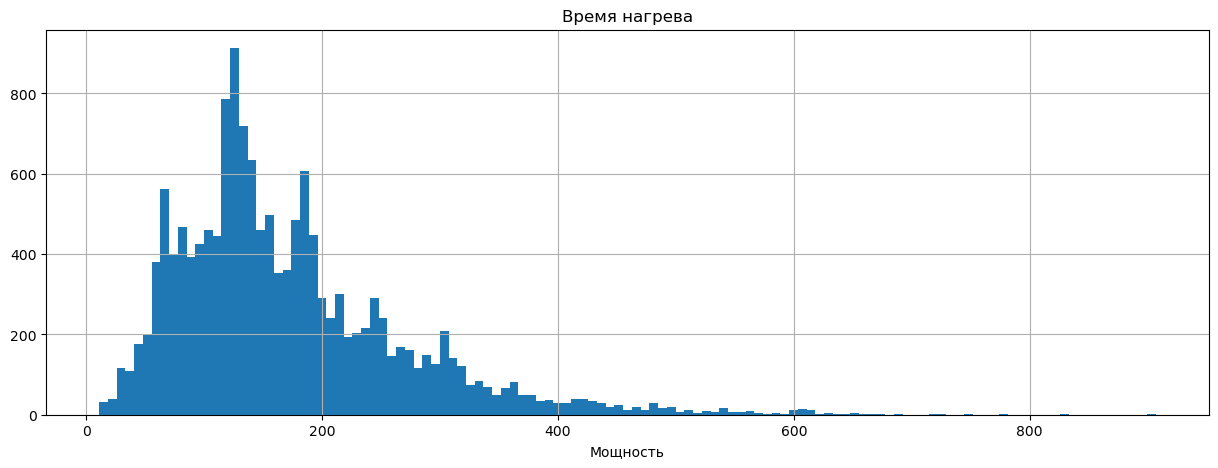

In [39]:
data_arc_new['arc_heating_time'].hist(bins=BINS, figsize=(15,5))
plt.title('Время нагрева')
plt.xlabel('Мощность')
plt.show()

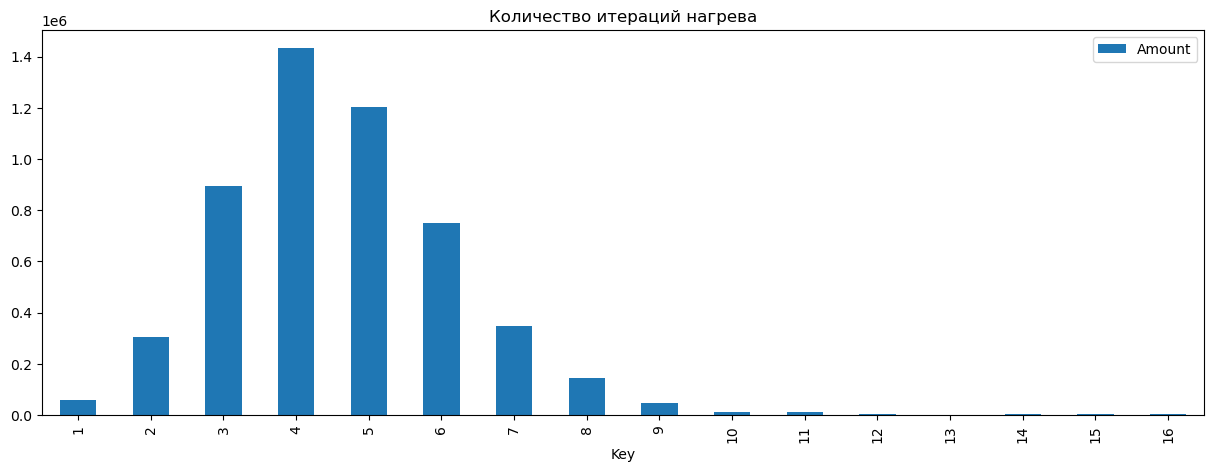

In [40]:
iterations = data_arc_new['key'].value_counts()
#Количество итераций нагрева до достижения оптимальной температуры 
iterations = pd.DataFrame(data=iterations)
iterations.reset_index(inplace=True)
iterations.columns = ('Amount', 'Key')
iterations = iterations.groupby('Key').agg({'Amount':'sum'})
iterations.plot(kind='bar', figsize=(15,5))
plt.title('Количество итераций нагрева')
plt.show()

In [41]:
iterations = iterations = data_arc_new['key'].value_counts()
iterations = pd.DataFrame(data=iterations)
iterations = iterations.reset_index()
iterations.columns = ('key', 'iterations')

In [42]:
iterations

,key,iterations
0,2108,16
1,1513,15
2,1689,15
3,2567,14
4,322,13
...,...,...
3208,112,1
3209,2472,1
3210,2025,1
3211,3059,1


In [43]:
data_arc_new.head()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934


#### Объединение

In [45]:
data_arc = data_arc_new.drop(columns=['arc_heating_start', 'arc_heating_finish'])
data_arc = data_arc.groupby('key').sum()

In [46]:
data_arc.head()

,apparent_power,reactive_power,arc_heating_time,full_power
key,,,,
1,3.036730,2.142821,1098,3.718736
2,2.139408,1.453357,811,2.588349
3,4.063641,2.937457,655,5.019223
4,2.706489,2.056992,741,3.400038
5,2.252950,1.687991,869,2.816980


In [47]:
data_arc = data_arc.merge(iterations, on='key')

In [48]:
data_arc.head()

,key,apparent_power,reactive_power,arc_heating_time,full_power,iterations
0,1,3.036730,2.142821,1098,3.718736,5
1,2,2.139408,1.453357,811,2.588349,4
2,3,4.063641,2.937457,655,5.019223,5
3,4,2.706489,2.056992,741,3.400038,4
4,5,2.252950,1.687991,869,2.816980,4


In [49]:
data_arc

,key,apparent_power,reactive_power,arc_heating_time,full_power,iterations
0,1,3.036730,2.142821,1098,3.718736,5
1,2,2.139408,1.453357,811,2.588349,4
2,3,4.063641,2.937457,655,5.019223,5
3,4,2.706489,2.056992,741,3.400038,4
4,5,2.252950,1.687991,869,2.816980,4
...,...,...,...,...,...,...
3208,3237,2.541872,2.025417,909,3.250657,5
3209,3238,1.374821,1.038103,546,1.723937,3
3210,3239,4.848005,3.541541,1216,6.014480,8
3211,3240,3.317679,2.373552,839,4.082920,5


#### Вывод

In [51]:
data_arc_new.describe()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
count,14872.000000,14872,14872,14872.000000,14872.000000,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112,171.688004,0.823385
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,11.000000,0.275718
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175,107.000000,0.578813
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667,147.000000,0.746591
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201,214.000000,1.030390
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,907.000000,1.898158
std,934.661090,NaN,NaN,0.258916,0.197623,98.193604,0.323494


Таблица состоит из:

* key — номер партии;
* arc_heating_start — время начала нагрева;
* arc_heating_finish — время окончания нагрева;
* apparent_power — значение активной мощности;
* reactive_power — значение реактивной мощности.

Дополнительно добавлены:
* arc_heating_time - время нагрева
* full_power - полная мощность

Изначально таблица содержит 14876 строк, ни один столбец не содержит пропусков.
Конечная таблица содержит 3214 строк, вследствие объединения строк по Key.

В ходе предобработки были изменены типы данных для столбцов, содержащих время; был обработан выброс в столбце reactive_power. Остальные выбросы пока что не обрабатываем.

После EDA, можно сказать, что:
* признаки имеют околонормальное распределение с бимодальностью и ассиметрией
* apparent_power имеет пик в значении 0.5
* reactive_power имеет пик в значении 0.37
* arc_heating_time имеет пик в значении 170
* наибольшее количество итераций для нагрева - 4

### data_bulk_new

In [54]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [55]:
data_bulk_new.columns = data_bulk_new.columns.str.lower()

In [56]:
data_bulk_new.columns = data_bulk_new.columns.str.replace(' ', '_')

In [57]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


#### Предобработка

Удалим более 50% пропусков

In [60]:
data_bulk_new.isna().sum() / len(data_bulk_new)

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

In [61]:
data_bulk_new = data_bulk_new.drop(columns=['bulk_1', 
                                            'bulk_2', 
                                            'bulk_3', 
                                            'bulk_4', 
                                            'bulk_5', 
                                            'bulk_6', 
                                            'bulk_7', 
                                            'bulk_8', 
                                            'bulk_9', 
                                            'bulk_10', 
                                            'bulk_11', 
                                            'bulk_13'])

In [62]:
data_bulk_new = data_bulk_new.fillna(0)

Так как данные невозможно восстановить, заполним пропуски значением 0

In [64]:
data_bulk_new = data_bulk_new.astype('int')

In [65]:
data_bulk_new

,key,bulk_12,bulk_14,bulk_15
0,1,206,150,154
1,2,206,149,154
2,3,205,152,153
3,4,207,153,154
4,5,203,151,152
...,...,...,...,...
3124,3237,252,130,206
3125,3238,254,108,106
3126,3239,158,270,88
3127,3240,0,192,54


In [66]:
data_bulk_new.describe()

,key,bulk_12,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,203.948226,152.706616,115.319271
std,933.337642,151.419639,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000
25%,816.000000,105.000000,104.000000,0.000000
50%,1622.000000,206.000000,148.000000,106.000000
75%,2431.000000,263.000000,202.000000,204.000000
max,3241.000000,1849.000000,636.000000,405.000000


Таблица состоит из: 
    
* key — номер партии;
* Bulk 1 … Bulk 15 — объём подаваемого материала.

Таблица содержит 3129 строк, значение NaN, вероятно, означает, что материал не подавался. 
Столбцы, которые содержат более половины пропусков были удалены. Пропуски были заполнены значением 0.

### data_bulk_time_new

In [69]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [70]:
data_bulk_time_new.columns = data_bulk_time_new.columns.str.lower()

In [71]:
data_bulk_time_new.columns = data_bulk_time_new.columns.str.replace(' ', '_')

In [72]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [73]:
for column in data_bulk_time_new.columns:
    if data_bulk_time_new[column].dtype == 'object':
        data_bulk_time_new[column] = pd.to_datetime(data_bulk_time_new[column])

In [74]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


Таблица состоит из: 
    
* key — номер партии;
* Bulk 1 … Bulk 15 — время подачи материала.

Таблица содержит 3129 строк, во всех столбцах Bulk присутствуют пропуски в разном количестве. Вследствие невозможности заполнить пропуски, принято решение оставить их

### data_gas_new

In [77]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [78]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [79]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': 'gas_1'})

In [80]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


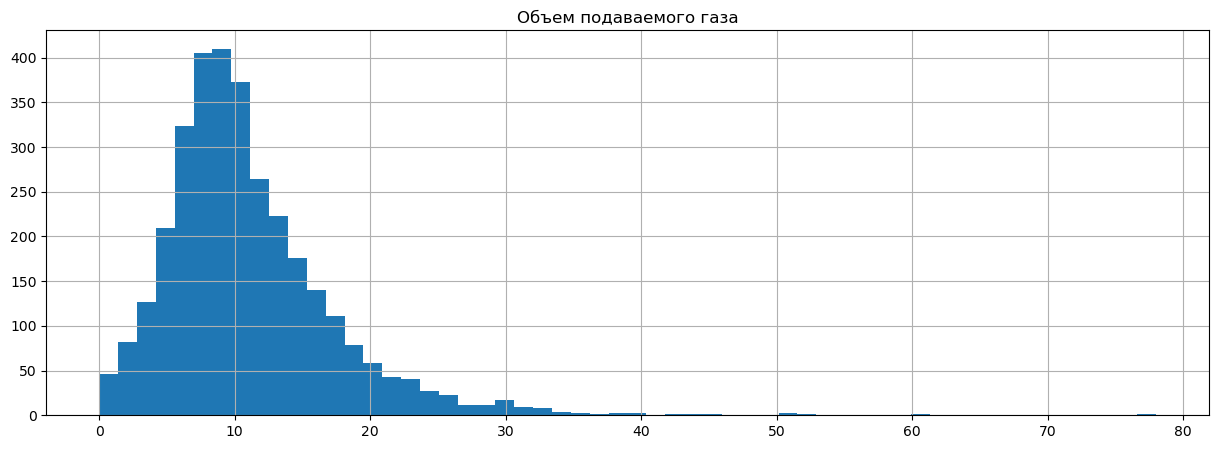

In [81]:
data_gas_new.set_index('key').hist(bins=(int(math.sqrt(data_gas_new['key'].count()))), figsize=(15,5))
plt.title('Объем подаваемого газа')
plt.show()

Таблица состоит из: 
    
* key — номер партии;
* Газ 1 — объём подаваемого газа.

Таблица содержит 3239 строк, ни один столбец не содержит пропусков.

Объем подаваемого газа имеет околонормальное распределение с большой ассиметрией и пиком в значении 9. Ассиметрия вызвана большим значением выбросов.

### data_temp_new 

In [84]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [85]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [86]:
data_temp_new = data_temp_new.rename(columns={'Время замера': 'timestamp',
                                           'Температура': 'temperature'})
data_temp_new['timestamp'] = pd.to_datetime(data_temp_new['timestamp'])

In [87]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   timestamp    18092 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [88]:
data_temp_new = data_temp_new.dropna()

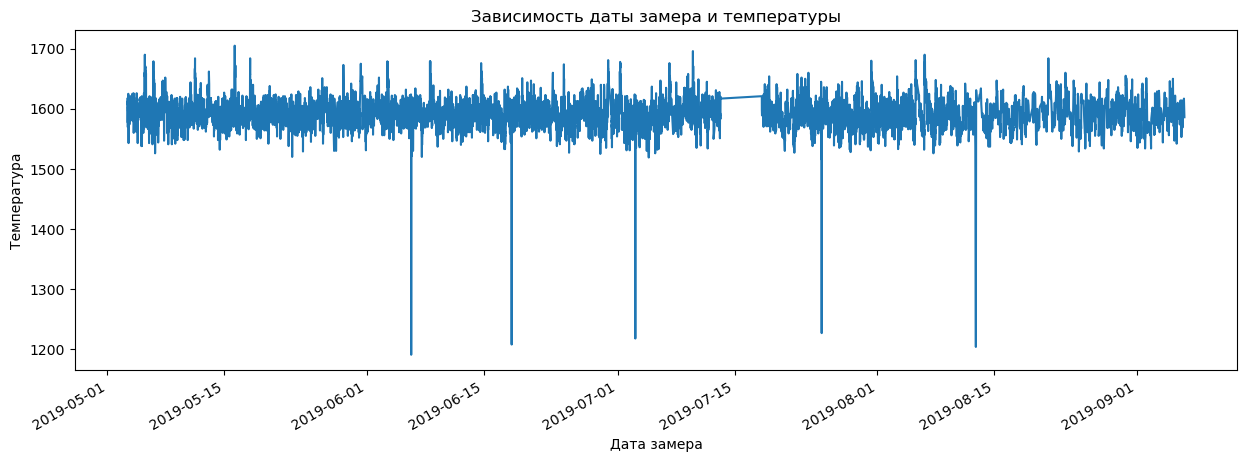

In [89]:
data_temp_new.set_index('timestamp')['temperature'].plot(figsize=(15,5))
plt.title('Зависимость даты замера и температуры')
plt.xlabel('Дата замера')
plt.ylabel('Температура')
plt.show()

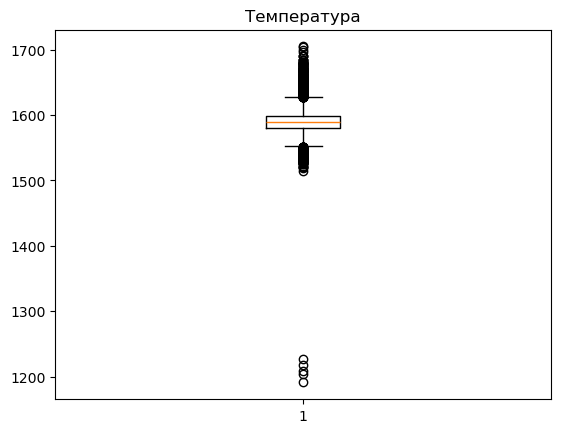

In [90]:
plt.boxplot(data_temp_new['temperature'])
plt.title('Температура')
plt.show()

Удалим значения температуры ниже 1300

In [92]:
data_temp_new = data_temp_new.query('temperature > 1300')

#### Объединение

In [94]:
data_temp = data_temp_new.groupby(by = 'key').agg(['first', 'last']).reset_index()

In [95]:
data_temp.columns = ['key', 'first_temp_ts', 'finish_temp_ts', 'first_temp', 'final_temp']

In [96]:
data_temp

,key,first_temp_ts,finish_temp_ts,first_temp,final_temp
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...,...
3210,3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1569.0,1569.0
3211,3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1584.0,1584.0
3212,3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1598.0,1598.0
3213,3240,2019-09-06 15:25:21,2019-09-06 15:25:21,1617.0,1617.0


In [97]:
iterations = data_temp_new['key'].value_counts()
iterations = pd.DataFrame(data=iterations)
iterations = iterations.reset_index()
iterations.columns = ('key', 'iterations')

In [98]:
iterations.sort_values(by='key')

,key,iterations
966,1,6
1283,2,5
1193,3,6
1685,4,5
1735,5,5
...,...,...
2723,3237,1
2724,3238,1
2725,3239,1
2726,3240,1


In [99]:
iterations.loc[iterations['iterations'] == 1]

,key,iterations
2475,2993,1
2476,2992,1
2477,2991,1
2478,2990,1
2479,2995,1
...,...,...
3210,2747,1
3211,2748,1
3212,2749,1
3213,2750,1


In [100]:
data_temp

,key,first_temp_ts,finish_temp_ts,first_temp,final_temp
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...,...
3210,3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1569.0,1569.0
3211,3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1584.0,1584.0
3212,3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1598.0,1598.0
3213,3240,2019-09-06 15:25:21,2019-09-06 15:25:21,1617.0,1617.0


In [101]:
data_temp = data_temp.query('key<2475')

Таблица состоит из: 
    
* key — номер партии;
* Время замера — время замера;
* Температура — значение температуры.

Таблица содержит 18092 строк, столбец температуры содержит пропуски. Было принято решение удалить пропуски, вследствие невозможности восстановления данных.

Были добавлены новые признаки, такие как:
* first_temp - первое значение температуры
* final_temp - последнее значение температуры

Так же было принято решение удалить строки со значением key > 2475, так как количество итераций было равно 1, значение столбцов first_temp и final_temp было бы одинаковым, что негативно повлияло бы на обучение модели.

### data_wire_new

In [104]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [106]:
data_wire_new.columns = data_wire_new.columns.str.lower()
data_wire_new.columns = data_wire_new.columns.str.replace(' ', '_')

In [107]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [108]:
data_wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Удалю более 50 % пропусков

In [110]:
data_wire_new.isna().sum() / len(data_wire_new)

key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

In [111]:
data_wire_new = data_wire_new[['key', 'wire_1']]

In [112]:
data_wire_new = data_wire_new.fillna(0)

In [113]:
data_wire_new.head()

,key,wire_1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236


Таблица состоит из: 
    
* key — номер партии;
* Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

Таблица содержит 3081 строку, в разных столбцах Wire имеется разное количество пропусков. Было принято решение удалить столбцы, имеющие более половины пропусков. Оставшиеся пропуски заполены 0

### data_wire_time_new

In [116]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [118]:
data_wire_time_new.columns = data_wire_time_new.columns.str.lower()
data_wire_time_new.columns = data_wire_time_new.columns.str.replace(' ', '_')

In [119]:
for column in data_wire_time_new.columns:
    if data_wire_time_new[column].dtype == 'object':
        data_wire_time_new[column] = pd.to_datetime(data_wire_time_new[column])

In [120]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Таблица состоит из: 
    
* key — номер партии;
* Wire 1 … Wire 15 — время подачи проволочных материалов.

Таблица содержит 3081 строку, в разных столбцах Wire есть разное количество пропусков. 

## Объединение данных

In [123]:
data_full = data_arc.merge(data_bulk_new, on='key', how='left')
data_full = data_full.merge(data_gas_new, on='key', how='left')
data_full = data_full.merge(data_temp, on='key', how='left')
data_full = data_full.merge(data_wire_new, on='key', how='left')

In [124]:
data_full.head()

,key,apparent_power,reactive_power,arc_heating_time,full_power,iterations,bulk_12,bulk_14,bulk_15,gas_1,first_temp_ts,finish_temp_ts,first_temp,final_temp,wire_1
0,1,3.036730,2.142821,1098,3.718736,5,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,60.059998
1,2,2.139408,1.453357,811,2.588349,4,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,96.052315
2,3,4.063641,2.937457,655,5.019223,5,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,91.160157
3,4,2.706489,2.056992,741,3.400038,4,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,89.063515
4,5,2.252950,1.687991,869,2.816980,4,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,89.238236


In [125]:
data_full.describe()

,key,apparent_power,reactive_power,arc_heating_time,full_power,iterations,bulk_12,bulk_14,bulk_15,gas_1,first_temp_ts,finish_temp_ts,first_temp,final_temp,wire_1
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3127.000000,3127.000000,3127.000000,3211.000000,2450,2450,2450.000000,2450.000000,3079.000000
mean,1622.907874,3.067683,2.254693,794.691566,3.811201,4.628696,204.078670,152.740966,115.393028,11.086005,2019-06-20 12:03:24.689387776,2019-06-20 12:41:29.230612224,1589.037143,1595.347347,100.052792
min,1.000000,0.267676,0.196228,57.000000,0.331897,1.000000,0.000000,0.000000,0.000000,0.008399,2019-05-03 11:02:04,2019-05-03 11:30:38,1519.000000,1541.000000,0.000000
25%,817.000000,2.236693,1.631855,571.000000,2.775577,4.000000,105.000000,104.000000,0.000000,7.095758,2019-05-26 23:25:44.249999872,2019-05-26 23:48:19,1572.000000,1587.000000,70.240558
50%,1623.000000,2.984607,2.177210,770.000000,3.694535,4.000000,206.000000,148.000000,106.000000,9.855382,2019-06-19 07:35:16,2019-06-19 08:06:20,1588.000000,1593.000000,100.151992
75%,2432.000000,3.775574,2.788381,983.000000,4.697427,6.000000,263.000000,202.000000,204.000000,13.810471,2019-07-11 04:57:35.249999872,2019-07-11 05:36:48.249999872,1605.000000,1599.000000,125.842081
max,3241.000000,12.375636,8.949049,4189.000000,15.288271,16.000000,1849.000000,636.000000,405.000000,77.995040,2019-08-09 16:02:47,2019-08-09 16:15:59,1679.000000,1700.000000,330.314424
std,934.844882,1.208719,0.894787,332.439136,1.502848,1.608860,151.380141,81.067309,84.465339,6.177946,NaN,NaN,25.012562,16.075610,42.852695


Для образования конечного датасета было принято решение использовать:
* data_arc
* data_bulk_new
* data_temp
* data_wire_new

Получился датасет с количеством строк, равным 3214. 

Датасеты с датами в своем изначальном виде нет смысла использовать

### Корреляционный анализ 

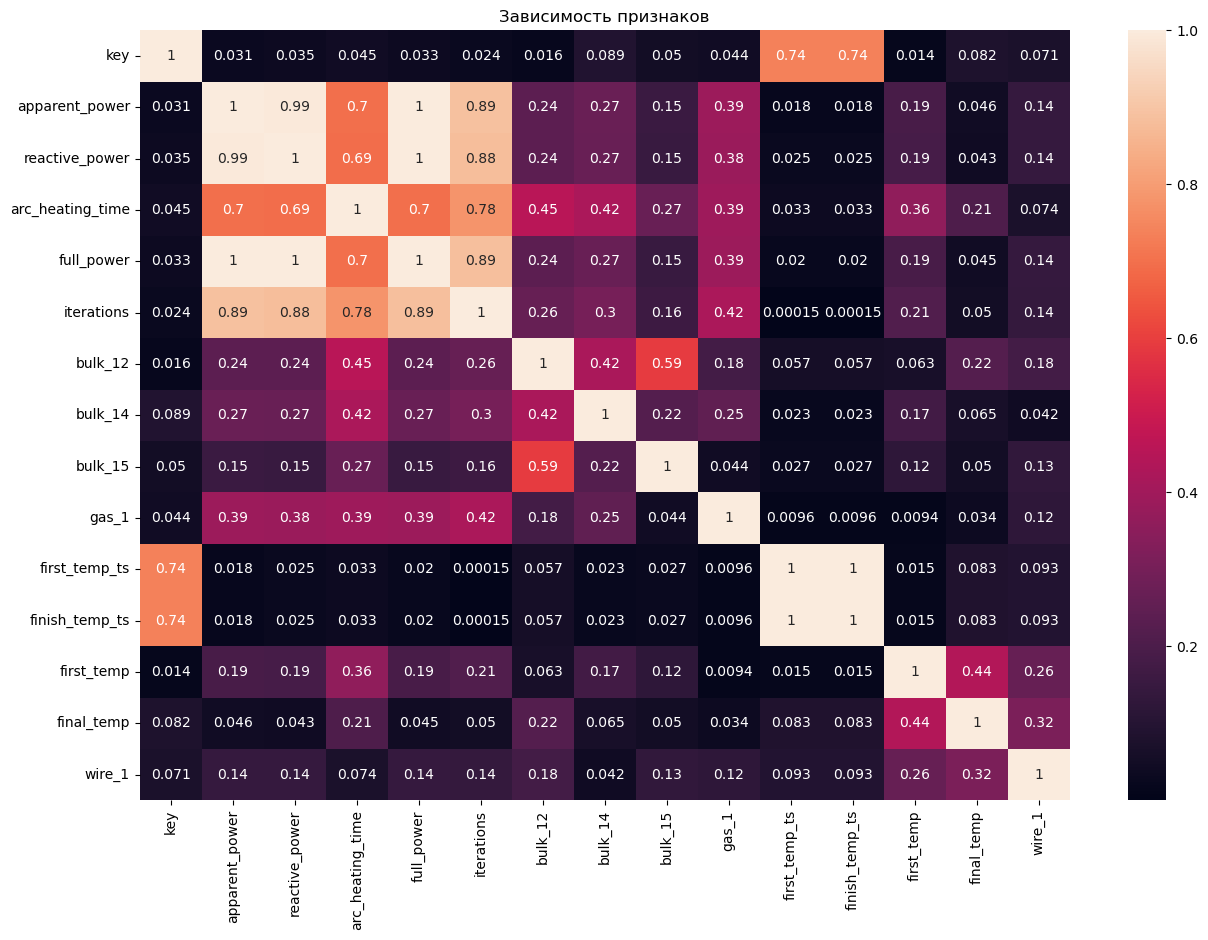

In [128]:
plt.figure(figsize=(15,10))
sns.heatmap(data_full.corr().abs(), annot=True)
plt.title('Зависимость признаков')
plt.show()

Сильная корреляция между признаками:
* apparent_power
* reactive_power
* arc_heating_time
* full_power
* iterations

Так как имеется мультиколлинеарность, следует убрать:
* full_power, apparent_power

In [130]:
data_full = data_full.drop(columns={'full_power', 'apparent_power'})

## Подготовка данных

In [132]:
data_full.head()

,key,reactive_power,arc_heating_time,iterations,bulk_12,bulk_14,bulk_15,gas_1,first_temp_ts,finish_temp_ts,first_temp,final_temp,wire_1
0,1,2.142821,1098,5,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,60.059998
1,2,1.453357,811,4,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,96.052315
2,3,2.937457,655,5,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,91.160157
3,4,2.056992,741,4,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,89.063515
4,5,1.687991,869,4,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,89.238236


In [133]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               3213 non-null   int64         
 1   reactive_power    3213 non-null   float64       
 2   arc_heating_time  3213 non-null   int32         
 3   iterations        3213 non-null   int64         
 4   bulk_12           3127 non-null   float64       
 5   bulk_14           3127 non-null   float64       
 6   bulk_15           3127 non-null   float64       
 7   gas_1             3211 non-null   float64       
 8   first_temp_ts     2450 non-null   datetime64[ns]
 9   finish_temp_ts    2450 non-null   datetime64[ns]
 10  first_temp        2450 non-null   float64       
 11  final_temp        2450 non-null   float64       
 12  wire_1            3079 non-null   float64       
dtypes: datetime64[ns](2), float64(8), int32(1), int64(2)
memory usage: 313.9 KB


Удалим пропуски

In [135]:
data_full = data_full.dropna()

In [136]:
data_full.describe()

,key,reactive_power,arc_heating_time,iterations,bulk_12,bulk_14,bulk_15,gas_1,first_temp_ts,finish_temp_ts,first_temp,final_temp,wire_1
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304,2304,2304.000000,2304.000000,2304.000000
mean,1238.592882,2.302764,808.565538,4.699219,208.219618,153.823351,119.693576,11.352785,2019-06-20 11:50:27.542968832,2019-06-20 12:29:14.774305792,1587.375868,1593.355903,102.453554
min,1.000000,0.196228,57.000000,1.000000,0.000000,0.000000,0.000000,0.008399,2019-05-03 11:02:04,2019-05-03 11:30:38,1519.000000,1541.000000,0.000000
25%,623.750000,1.669414,582.500000,4.000000,105.000000,105.000000,0.000000,7.278086,2019-05-26 23:44:44.750000128,2019-05-27 00:20:35,1571.000000,1587.000000,73.136698
50%,1242.500000,2.227039,778.000000,5.000000,206.000000,149.000000,107.000000,10.090391,2019-06-19 10:16:21,2019-06-19 10:52:36,1587.000000,1593.000000,101.103600
75%,1849.250000,2.829327,993.250000,6.000000,283.250000,204.000000,204.000000,14.175144,2019-07-11 01:51:02.249999872,2019-07-11 02:15:42.750000128,1603.000000,1598.000000,128.138393
max,2474.000000,8.949049,4189.000000,16.000000,1849.000000,636.000000,405.000000,77.995040,2019-08-09 16:02:47,2019-08-09 16:15:59,1660.000000,1653.000000,330.314424
std,707.132440,0.904876,341.423249,1.606348,157.570993,81.721845,84.835975,6.377360,NaN,NaN,23.620686,11.217430,43.629625


Для обучения удалим лишние столбцы

In [138]:
data_full = data_full.drop(columns={'key', 'first_temp_ts', 'finish_temp_ts'})

In [139]:
data_full.head()

,reactive_power,arc_heating_time,iterations,bulk_12,bulk_14,bulk_15,gas_1,first_temp,final_temp,wire_1
0,2.142821,1098,5,206.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998
1,1.453357,811,4,206.0,149.0,154.0,12.555561,1581.0,1602.0,96.052315
2,2.937457,655,5,205.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157
3,2.056992,741,4,207.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515
4,1.687991,869,4,203.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236


data_full['temp_diff'] = data_full['final_temp'] - data_full['first_temp']

data_full['final_temp'] = data_full['temperature']/data_full['iterations_y']
data_full['final_temp'] = data_full['final_temp'].astype(int)

In [142]:
data_full[['bulk_12', 'bulk_14', 'bulk_15', 'first_temp', 'final_temp']] = data_full[['bulk_12', 'bulk_14', 'bulk_15', 'first_temp', 'final_temp']].astype(int)

In [143]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2304 entries, 0 to 2449
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   reactive_power    2304 non-null   float64
 1   arc_heating_time  2304 non-null   int32  
 2   iterations        2304 non-null   int64  
 3   bulk_12           2304 non-null   int32  
 4   bulk_14           2304 non-null   int32  
 5   bulk_15           2304 non-null   int32  
 6   gas_1             2304 non-null   float64
 7   first_temp        2304 non-null   int32  
 8   final_temp        2304 non-null   int32  
 9   wire_1            2304 non-null   float64
dtypes: float64(3), int32(6), int64(1)
memory usage: 144.0 KB


In [144]:
data_full

,reactive_power,arc_heating_time,iterations,bulk_12,bulk_14,bulk_15,gas_1,first_temp,final_temp,wire_1
0,2.142821,1098,5,206,150,154,29.749986,1571,1613,60.059998
1,1.453357,811,4,206,149,154,12.555561,1581,1602,96.052315
2,2.937457,655,5,205,152,153,28.554793,1596,1599,91.160157
3,2.056992,741,4,207,153,154,18.841219,1601,1625,89.063515
4,1.687991,869,4,203,151,152,5.413692,1576,1602,89.238236
...,...,...,...,...,...,...,...,...,...,...
2443,2.215379,747,5,0,193,0,13.673635,1608,1588,119.115357
2445,1.205958,478,3,207,160,205,9.812350,1627,1591,115.053116
2447,0.344489,161,1,0,0,0,14.794499,1627,1592,140.125443
2448,2.505007,636,5,234,129,225,30.036047,1621,1594,165.852961


In [145]:
X = data_full.drop(columns='final_temp')
y = data_full['final_temp']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

Были удалены столбцы
* key - из-за своей ненадобности
* first_temp_ts, finish_temp_ts - нет необходимости использовать даты


## Обучение моделей

### Linear Regression

In [149]:
model_lr = LinearRegression()

scores = abs(cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
print('MAE:', scores.mean())

MAE: 6.588384029524221


Полученное значение MAE = 6.58

### RandomForest

In [ ]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
params = {
    'n_estimators': [50, 150 ,300],
    'max_depth': [10, 15, 20]    
}
forest = GridSearchCV(model_rf, params, cv=5, scoring='neg_mean_absolute_error')
forest.fit(X_train, y_train)

print('Гиперпараметры', forest.best_params_)
print('MAE', abs(forest.best_score_))

RandomForest имеет показатель MAE = 6.59

### CatBoostRegressor

In [ ]:
model_cb = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', verbose=False)

params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': range(20, 60, 20)}

cat = GridSearchCV(model_cb, params, cv=5, scoring='neg_mean_absolute_error')
cat.fit(X_train, y_train)

print('Гиперпараметры', cat.best_params_)
print('MAE', abs(cat.best_score_))

При гиперпараметрах:
* depth = 6
* iterations = 40
* l2_leaf_reg = 5
* learning_rate = 0.1 

модель CatBoostRegressor имеет показатель метрики MAE = 6.51

Модель будем использовать для проверки на тестовых данных

### LightGBM

In [ ]:
model_lgbm = LGBMRegressor()

parameters = {"learning_rate" : [0.01, 0.1],
               "n_estimators": range (5, 7)
             }


lgbm = GridSearchCV(model_lgbm,
    parameters,
    cv=5,
    scoring='neg_mean_absolute_error')

lgbm.fit(X_train, y_train)
print('Гиперпараметры', lgbm.best_params_)

print('MAE', abs(lgbm.best_score_))

При гиперпараметрах:
* n_estimators = 6
* learning_rate = 0.1 

модель LGBM имеет показатель метрики MAE = 7.17, что больше чем требуемый порог

### Вывод

После проверки 4 моделей, имеем следующие результаты метрики MAE:
* Linear Regression - 6.58
* RandomForest - 6.59
* CatBoost - 6.51
* LightGBM - 7.17

Для дальнейшей проверки возьмем модель CatBoost, так как у этой модели лучший результат MAE

### CatBoost features importances на тестовых

In [ ]:
model = CatBoostRegressor(
    depth=10,
    learning_rate=0.1,
    loss_function='MAE',
    iterations=40,
    l2_leaf_reg=9,
    random_state=RANDOM_STATE,
    verbose = False
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, pred))

plot_data = {
    'features': X_test.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', inplace=True)
plt.figure(figsize=(15, 9))

sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor')
plt.xlabel('Степень важности')
plt.ylabel('Признак')
plt.show()

Итоговое значение модели CatBoost = 6.56, что соответствует пределу в 6,8.

Наибольший вес имеют признаки 
* first_temp
* arc_heating_time

Наименьший вес:
* reactive_power

## Вывод

При выполнении проекта была построена модель для предсказания температуры сплава 

На этапе загрузки и предобработки были: 
* исследованы признаки, их распределения
* изменены типы данных для некоторых столбцов
* данные проверены на дубликаты
* убраны аномалии в данных
* выбросы решено не трогать, так как их большое количество и MAE - робастная метрика

На этапе объединения данных:
* был создан общий датафрейм со всеми изначальными данными
* проведен корреляционный анализ

На этапе подготовки данных:
* были окончательно удалены столбцы, не имеющие важности
* добвален новый признак

На этапе обучения моделей были построены 4 модели:
* Linear Regression
* RandomForest
* CatBoostRegressor
* LightGBM

Linear Regression показала значение MAE = 6.58

LightGBM показала значение метрики MAE = 6.59

CatBoost показала лучший результат  MAE = 6.51 при гиперпараметрах:
* depth = 6
* iterations = 40
* l2_leaf_reg = 5
* learning_rate = 0.1
* random_state = 40624

Показатель модели CatBoost на тестовой выборке = 6.56. 

Наибольший вес имеют признаки:
* first_temp
* arc_heating_time

Показатели модели, вероятно можно улучшить, если взять более широкий спектр возможных для модели гиперпараметров. Так же если добавить дополнительные признаки, либо удалить некоторые имеющиеся признаки.